#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 2 - Unsupervised Deep Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving unsupervised problems. For simplicity and to allow continuity with the kind of data you have seen before, the homework will be based on images of handwritten digits (MNIST). However, you can optionally explore different image collections (e.g., [Caltech](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) or [Cifar](https://www.cs.toronto.edu/~kriz/cifar.html)) or other datasets based on your interests. The basic tasks for the homework will require to test and analyze the convolutional autoencoder implemented during the Lab practice. If you prefer, you can opt for a fully-connected autoencoder, which should achieve similar performance considering the relatively small size of the MNIST images. As for the previous homework, you should explore the use of advanced optimizers and regularization methods. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. More advanced tasks will require the exploration of denoising and variational architectures.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	1 pt: implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction
*	1 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	1 pt: implement and test denoising (convolutional) autoencoder
*	1 pt: fine-tune the (convolutional) autoencoder using a supervised classification task (you can compare classification accuracy and learning speed with results achieved in homework 1)
*	1 pt: explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes
*	2 pt: implement variational (convolutional) autoencoder or GAN




## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import seaborn as sns
import sklearn
import optuna 
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm.notebook import tqdm # this module is useful to plot progress bars
import pathlib
import plotly
import imageio
import gc

import torch
import torchvision
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch import nn

from optuna.trial import TrialState

In [2]:
### Set the random seed for reproducible results
torch.manual_seed(753)
np.random.seed(753)

# MNIST dataset

In [3]:
### Download the data and create dataset
data_dir = 'dataset'

# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

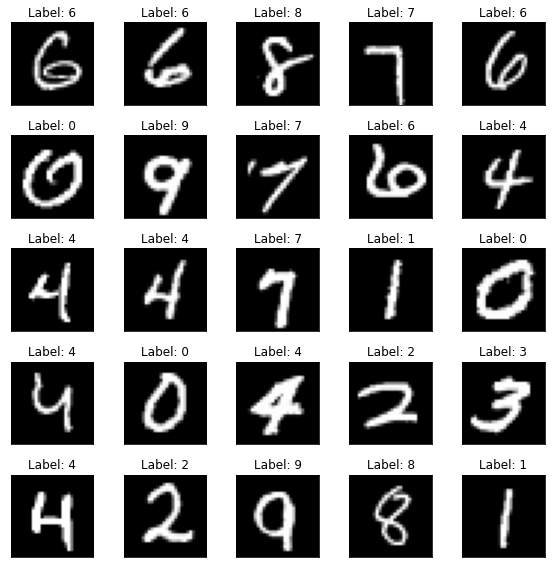

In [4]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

# GAN


In [5]:
#ref https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
nz = 64 # latent vector size

#for the option k=1, see https://arxiv.org/pdf/1406.2661.pdf
#k is a hyperparameter that indicates the number of steps to apply to the discriminator. 
#We will keep the value of k as 1 as this is the least expensive training option.
k = 1 # number of steps to apply to the discriminator

path_images_generated = "GAN_generated"
os.makedirs(path_images_generated, exist_ok=True)

### Download the data and create dataset
data_dir = 'dataset'

# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

#interestingly, normalization does not need to occur as in the previous homework
#and values are mu = 0.500 and sigma = 0.500
GAN_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.500,), (0.500,))
])

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Set the train transform
train_dataset.transform = GAN_transforms
# Set the test transform
test_dataset.transform = GAN_transforms

In [6]:
class Generator(nn.Module):
    
    def __init__(self, nz):
        super().__init__()
        '''
        nz : the number of input features for the first linear layer of the generator network.
        '''
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        '''
        Every image is 28x28 = 784
        '''
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [8]:
generator = Generator(nz).to(device)
generator

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [9]:
discriminator = Discriminator().to(device)
discriminator

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [10]:
# optimizers, since training of generator and discriminator occurin different moments,
# two different optimizers are needed
optim_g = torch.optim.Adam(generator.parameters(), lr=0.0002)
optim_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function, for this problem it is binary since image can be either TRUE or FAKE
GAN_loss = nn.BCELoss()

#pil image is needed to build gif, which are cool :)
to_pil_image = transforms.ToPILImage()

In [11]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images   = [] # to store images generatd by the generator


#these functions will return vectors that have the size size equal to the batch size
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector, which will be used to generate images
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [12]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    
    #create tensors of 1s
    real_label = label_real(b_size)
    #create tensors of 0s
    fake_label = label_fake(b_size)
    
    optimizer.zero_grad()
    
    #see whether the discriminator is able to detect real images
    output_real = discriminator(data_real)
    loss_real = GAN_loss(output_real, real_label)
    
    #see whether the discriminator is able to detect fake images
    output_fake = discriminator(data_fake)
    loss_fake = GAN_loss(output_fake, fake_label)
    
    #propagate the loss
    loss_real.backward()
    loss_fake.backward()
    
    optimizer.step()
    
    del output_real, output_fake, real_label, fake_label
    
    return loss_real + loss_fake

In [13]:
# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    
    #create tensors of 1s
    real_label = label_real(b_size)
    
    optimizer.zero_grad()
    
    #see whether discriminator was able to detect fake images
    output = discriminator(data_fake)
    
    #here, it penalizes when discriminator assigns the "FAKE" label
    #i.e. when the output is "0" instead of being "1"- 
    #indeed loss is not null only when 
    #"output" is "0" (discriminator told it is fake)
    #rather being "1" (discriminator was fooled)  
    loss = GAN_loss(output, real_label)
    loss.backward()
    
    optimizer.step()
    
    del output, real_label
    
    return loss

In [14]:
# create the noise vector
noise = create_noise(64, nz)
EPOCHS = 500

discriminator.train()
generator.train()

for epoch in tqdm(range(EPOCHS)):
    loss_g = 0.0
    loss_d = 0.0
    cnt = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        batch_size = len(image_batch)
        
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(batch_size, nz)).detach()
            data_real = image_batch
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)

            
        data_fake = generator(create_noise(batch_size, nz))
        
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
        cnt += 1
        
        del data_fake, data_real, image_batch
    
    #the following lines are NEEDED to avoid filling the RAM with 
    #no more used tensors and gradients, 
    #if the notebook is being run LOCALLY
    loss_g = loss_g.detach()
    loss_d = loss_d.detach()  
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
        
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, 'GAN_generated/%03d.png' % (epoch))
    images.append(generated_img)
    
    epoch_loss_g = loss_g / cnt # total generator loss for the epoch
    epoch_loss_d = loss_d / cnt # total discriminator loss for the epoch
    
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    del generated_img
    gc.collect()
    
    print(f"Epoch {epoch} of {EPOCHS}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

Epoch 0 of 500
Generator loss: 1.41456008, Discriminator loss: 0.88488358
Epoch 1 of 500
Generator loss: 2.85779166, Discriminator loss: 1.41133690
Epoch 2 of 500
Generator loss: 5.17203474, Discriminator loss: 0.10043094
Epoch 3 of 500
Generator loss: 5.70523214, Discriminator loss: 0.25744283
Epoch 4 of 500
Generator loss: 1.72045851, Discriminator loss: 0.96046060
Epoch 5 of 500
Generator loss: 3.07359266, Discriminator loss: 1.01055264
Epoch 6 of 500
Generator loss: 1.96371710, Discriminator loss: 1.06391704
Epoch 7 of 500
Generator loss: 2.46541929, Discriminator loss: 0.92711180
Epoch 8 of 500
Generator loss: 2.00701880, Discriminator loss: 0.82566464
Epoch 9 of 500
Generator loss: 1.95151496, Discriminator loss: 1.13627350
Epoch 10 of 500
Generator loss: 2.26992702, Discriminator loss: 0.78174567
Epoch 11 of 500
Generator loss: 1.77482724, Discriminator loss: 0.97121072
Epoch 12 of 500
Generator loss: 2.84432864, Discriminator loss: 0.58945471
Epoch 13 of 500
Generator loss: 3.2

Epoch 110 of 500
Generator loss: 1.77766836, Discriminator loss: 0.86800790
Epoch 111 of 500
Generator loss: 1.77968335, Discriminator loss: 0.84852147
Epoch 112 of 500
Generator loss: 1.73263967, Discriminator loss: 0.86608166
Epoch 113 of 500
Generator loss: 1.79065788, Discriminator loss: 0.83799928
Epoch 114 of 500
Generator loss: 1.73035681, Discriminator loss: 0.85237706
Epoch 115 of 500
Generator loss: 1.78749454, Discriminator loss: 0.87368971
Epoch 116 of 500
Generator loss: 1.73695326, Discriminator loss: 0.89849186
Epoch 117 of 500
Generator loss: 1.76300943, Discriminator loss: 0.86297697
Epoch 118 of 500
Generator loss: 1.82227516, Discriminator loss: 0.82870251
Epoch 119 of 500
Generator loss: 1.83441877, Discriminator loss: 0.83936369
Epoch 120 of 500
Generator loss: 1.78541362, Discriminator loss: 0.88189191
Epoch 121 of 500
Generator loss: 1.78240526, Discriminator loss: 0.84924269
Epoch 122 of 500
Generator loss: 1.77471578, Discriminator loss: 0.85546070
Epoch 123 of

Epoch 218 of 500
Generator loss: 1.22120690, Discriminator loss: 1.10173559
Epoch 219 of 500
Generator loss: 1.17780411, Discriminator loss: 1.11347878
Epoch 220 of 500
Generator loss: 1.23939776, Discriminator loss: 1.08303654
Epoch 221 of 500
Generator loss: 1.21615171, Discriminator loss: 1.10059953
Epoch 222 of 500
Generator loss: 1.28212559, Discriminator loss: 1.08991253
Epoch 223 of 500
Generator loss: 1.19992101, Discriminator loss: 1.10553932
Epoch 224 of 500
Generator loss: 1.19756639, Discriminator loss: 1.09483540
Epoch 225 of 500
Generator loss: 1.24788928, Discriminator loss: 1.08375156
Epoch 226 of 500
Generator loss: 1.22324157, Discriminator loss: 1.11143386
Epoch 227 of 500
Generator loss: 1.23392200, Discriminator loss: 1.09310639
Epoch 228 of 500
Generator loss: 1.19762015, Discriminator loss: 1.09956491
Epoch 229 of 500
Generator loss: 1.20615125, Discriminator loss: 1.09894156
Epoch 230 of 500
Generator loss: 1.20089889, Discriminator loss: 1.11990237
Epoch 231 of

Epoch 326 of 500
Generator loss: 1.04546881, Discriminator loss: 1.20778394
Epoch 327 of 500
Generator loss: 1.02500570, Discriminator loss: 1.18924570
Epoch 328 of 500
Generator loss: 1.03800404, Discriminator loss: 1.19798088
Epoch 329 of 500
Generator loss: 1.04267991, Discriminator loss: 1.20083606
Epoch 330 of 500
Generator loss: 1.02820134, Discriminator loss: 1.21243167
Epoch 331 of 500
Generator loss: 1.02046728, Discriminator loss: 1.19952440
Epoch 332 of 500
Generator loss: 1.04766452, Discriminator loss: 1.18887699
Epoch 333 of 500
Generator loss: 1.02942979, Discriminator loss: 1.20204246
Epoch 334 of 500
Generator loss: 1.04871786, Discriminator loss: 1.20152164
Epoch 335 of 500
Generator loss: 1.06758928, Discriminator loss: 1.18723202
Epoch 336 of 500
Generator loss: 1.04467702, Discriminator loss: 1.19330502
Epoch 337 of 500
Generator loss: 1.05205500, Discriminator loss: 1.18304944
Epoch 338 of 500
Generator loss: 1.05217409, Discriminator loss: 1.18720722
Epoch 339 of

Epoch 434 of 500
Generator loss: 0.99133748, Discriminator loss: 1.22030807
Epoch 435 of 500
Generator loss: 1.01393223, Discriminator loss: 1.20847750
Epoch 436 of 500
Generator loss: 0.97815061, Discriminator loss: 1.22781610
Epoch 437 of 500
Generator loss: 0.97151256, Discriminator loss: 1.22470188
Epoch 438 of 500
Generator loss: 0.99340338, Discriminator loss: 1.22471297
Epoch 439 of 500
Generator loss: 0.99553508, Discriminator loss: 1.22660673
Epoch 440 of 500
Generator loss: 1.02880764, Discriminator loss: 1.22193027
Epoch 441 of 500
Generator loss: 1.00072753, Discriminator loss: 1.21585059
Epoch 442 of 500
Generator loss: 1.01203942, Discriminator loss: 1.21554899
Epoch 443 of 500
Generator loss: 0.97161895, Discriminator loss: 1.22252667
Epoch 444 of 500
Generator loss: 0.98793775, Discriminator loss: 1.22036731
Epoch 445 of 500
Generator loss: 0.98307192, Discriminator loss: 1.22749698
Epoch 446 of 500
Generator loss: 1.01656318, Discriminator loss: 1.21792936
Epoch 447 of

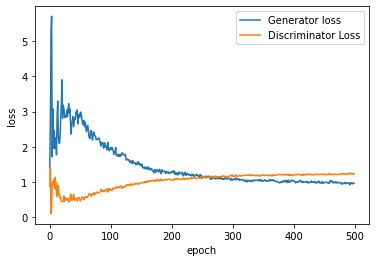

In [17]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('GAN_generated/generator_images.gif', imgs)

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label = 'Generator loss')
plt.plot(losses_d, label = 'Discriminator Loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig('GAN_generated/loss.png')

In [16]:
imageio.mimsave('GAN_generated/generator_images_reduced.gif', imgs[::2])

In [18]:
#save the GAN generator state
torch.save(generator.state_dict(),   'GAN_generator_params.pth')
torch.save(optim_g.state_dict(),     'GAN_g_optim_params.pth')

#save the GAN discriminator state
torch.save(discriminator.state_dict(),   'GAN_discriminator_params.pth')
torch.save(optim_d.state_dict(),         'GAN_d_optim_params.pth')